# 0.0 Functions and Imports

In [21]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
import dtype_diet
from IPython.display import display, HTML
from IPython.display import Image
import seaborn as sns
import sweetviz as sv
from scikitplot import metrics as mt

pd.set_option('display.float_format', lambda x: '%.2f' % x)

def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 20]
    plt.rcParams['font.size'] = 19
    display( HTML( '') )
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.max_columns = None
    sns.set(font_scale=1.5)
jupyter_settings()


def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n') )
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum() ) )

# 1.0 Loading data

In [2]:
df_users = pd.read_csv('../data/raw/train_users_2.csv', low_memory=True)
df_otimized = dtype_diet.report_on_dataframe(df_users)
df_users = dtype_diet.optimize_dtypes(df_users, df_otimized)

del(df_otimized)

In [11]:
df_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.00,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.00,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.00,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.00,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


# 2.0 Data Description

In [3]:
df1 = df_users.copy()

In [314]:
data_description(df_users)

Variables:

id                           object
date_account_created       category
timestamp_first_active        int64
date_first_booking         category
gender                     category
age                         float16
signup_method              category
signup_flow                    int8
language                   category
affiliate_channel          category
affiliate_provider         category
first_affiliate_tracked    category
signup_app                 category
first_device_type          category
first_browser              category
country_destination        category
dtype: object

Number of rows 213451

Number of columns 16

NA analysis
column id: False 0
column date_account_created: False 0
column timestamp_first_active: False 0
column date_first_booking: True 124543
column gender: False 0
column age: True 87990
column signup_method: False 0
column signup_flow: False 0
column language: False 0
column affiliate_channel: False 0
column affiliate_provider: False 0
column f

## 2.1 Change Data Type

In [4]:
# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S') 

#date_account_created
df1['date_account_created']= df1['date_account_created'].astype('datetime64[ns]')
                                           
#date_first_booking
df1['date_first_booking']= df1['date_first_booking'].astype('datetime64[ns]')

#signup_flow
df1['signup_flow']= df1['signup_flow'].astype(int)


## 2.2 Check unique values

In [87]:
aux1 = df1.select_dtypes('category')
for i in aux1.columns:
    print('column {}: {}'.format(i,aux1[i].unique().tolist() ), end='\n\n' )

column gender: ['-unknown-', 'MALE', 'FEMALE', 'OTHER']

column signup_method: ['facebook', 'basic', 'google']

column signup_flow: [0, 3, 2, 1, 24, 8, 6, 5, 10, 25, 12, 4, 16, 15, 20, 21, 23]

column language: ['en', 'fr', 'de', 'es', 'it', 'pt', 'zh', 'ko', 'ja', 'ru', 'pl', 'el', 'sv', 'nl', 'hu', 'da', 'id', 'fi', 'no', 'tr', 'th', 'cs', 'hr', 'ca', 'is']

column affiliate_channel: ['direct', 'seo', 'other', 'sem-non-brand', 'content', 'sem-brand', 'remarketing', 'api']

column affiliate_provider: ['direct', 'google', 'other', 'craigslist', 'facebook', 'vast', 'bing', 'meetup', 'facebook-open-graph', 'email-marketing', 'yahoo', 'padmapper', 'gsp', 'wayn', 'naver', 'baidu', 'yandex', 'daum']

column first_affiliate_tracked: ['untracked', 'omg', nan, 'linked', 'tracked-other', 'product', 'marketing', 'local ops']

column signup_app: ['Web', 'Moweb', 'iOS', 'Android']

column first_device_type: ['Mac Desktop', 'Windows Desktop', 'iPhone', 'Other/Unknown', 'Desktop (Other)', 'Android T

In [196]:
#Check unique values for age
df1[pd.notnull(df1['age'] ) ]['age'].astype(int).unique()

array([  38,   56,   42,   41,   46,   47,   50,   36,   37,   33,   31,
         29,   30,   40,   26,   32,   35,   59,   49,   44,   34,   28,
         19,   53,   52,   39,   57,   25,   54,   69,   63,   43,   55,
         65,   58,   61,   18,    5,   27,   45,   60,   48,   51,   64,
         72,   70,   67,   73, 2014,  104,   66,  105,   68,   95,   24,
         94,   75,   79,   62, 2013,   16,    4,   23,  101,   98,   76,
         74,   87,   92,  115,   71,   84,  107,   78,   99,  110,  102,
         82,   77,   22,   89,   21,   15,   20,  103,    2,   17,   86,
         97,   81,   90,   88,   80,  100,   91,  106,   83,   85,  108,
        113,  109,   93,   96, 1949,  111, 1931, 1932,  112, 1928,    1,
       1936, 1933, 1935, 1925, 1952,  150, 1927,  132, 1953, 1942, 1995,
       2008, 1924, 1929, 1947, 1938, 1926])

<AxesSubplot: xlabel='age', ylabel='Count'>

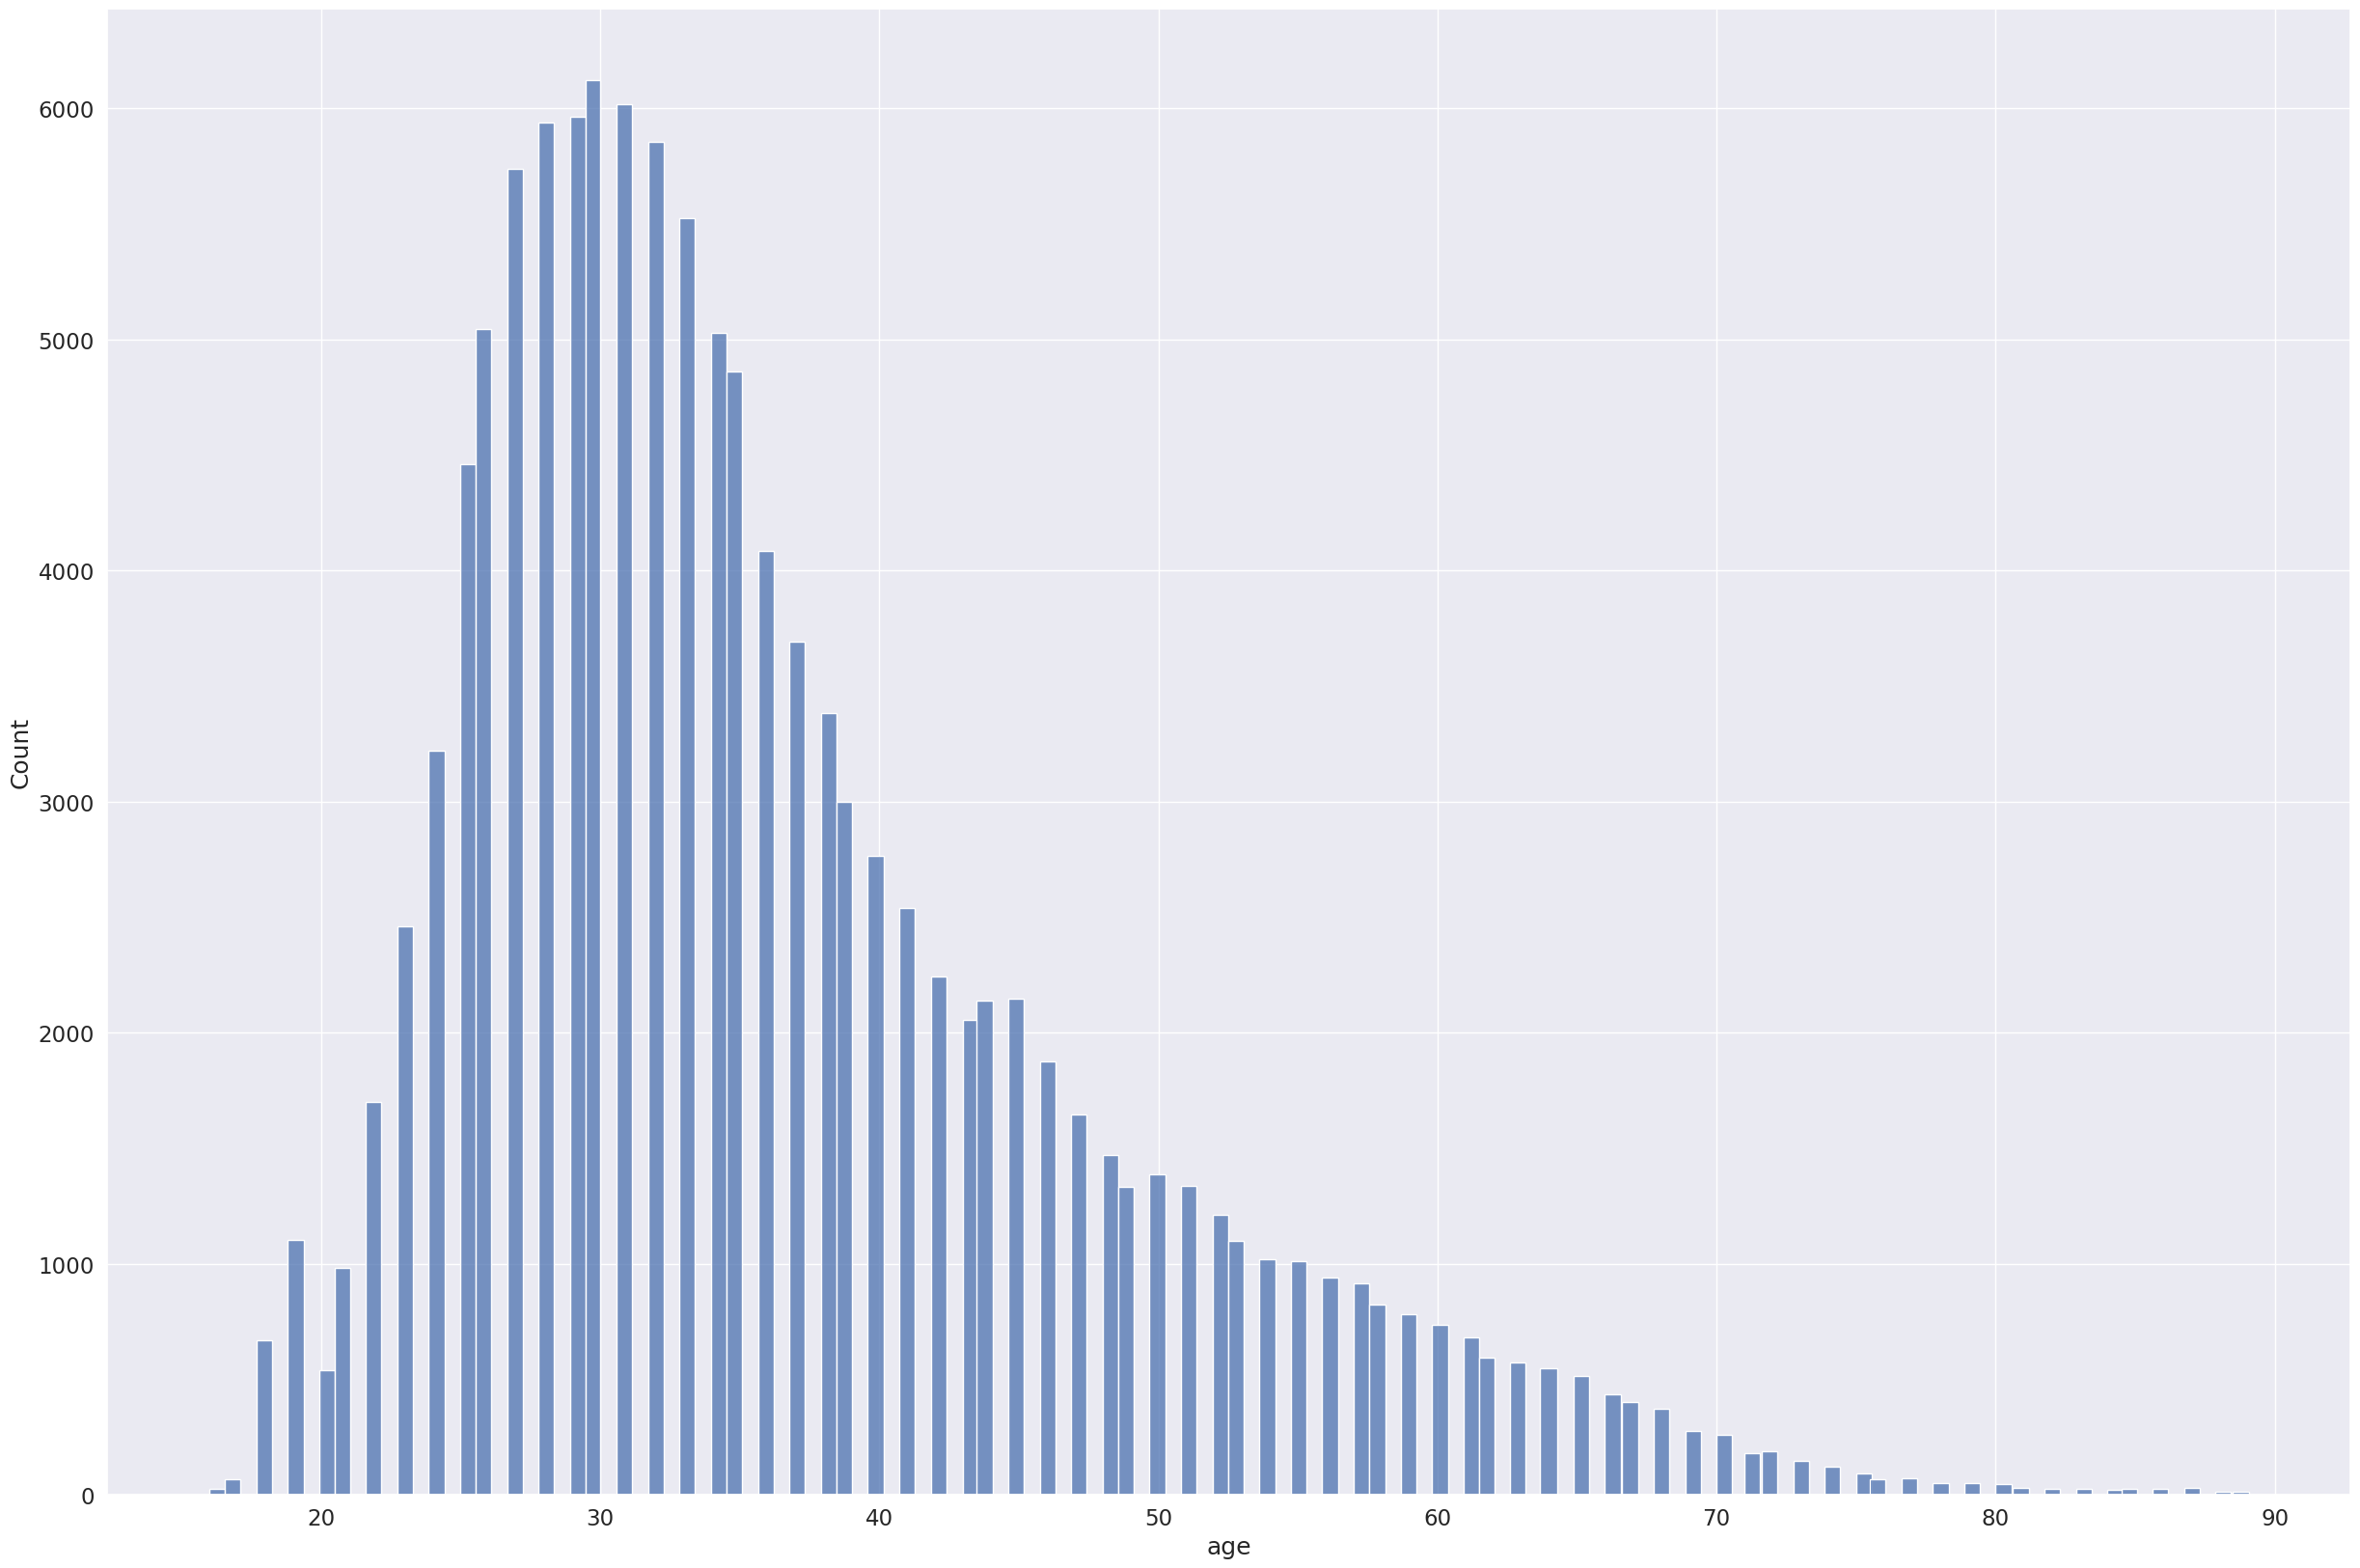

In [199]:
#checking distribution of age without NAs and filtering ages less than 90 and greater than 15
sns.histplot(x='age', data=df1[ (df1['age'] < 90) & (df1['age'] > 15 ) ] )

## 2.3 Check Balanced Data

In [60]:
df1['country_destination'].value_counts(normalize=True)

US      0.71
other   0.11
FR      0.05
IT      0.03
GB      0.03
ES      0.02
CA      0.02
DE      0.01
NL      0.01
AU      0.01
PT      0.00
NDF     0.00
Name: country_destination, dtype: float64

In [76]:
df1['gender'].value_counts(normalize=True)

-unknown-   0.45
FEMALE      0.30
MALE        0.26
OTHER       0.00
Name: gender, dtype: float64

## 2.4 NA cleaning/filling

In [5]:
# date_first_booking
df1['date_first_booking'] = df1[['date_first_booking','date_account_created']].apply(lambda x: x[1] if pd.isna(x[0]) else x[0] , axis=1)

#age
age_median = df1[( (df1['age'] < 90) & (df1['age'] > 15) ) & (pd.notnull(df1['age'] ) ) ]['age'].median().astype(int)
df1['age'] = df1['age'].apply(lambda x: int(x) if  (15 < x < 90) else age_median)
df1['age'].astype(int)
# column first_affiliate_tracked
df1['first_affiliate_tracked'].fillna('untracked', inplace=True)
#gender
df1['gender'] = df1['gender'].apply(lambda x: '-unknown-' if x == 'OTHER' else x)
df1['gender'] = df1['gender'].astype('category')

# 3.0 Descriptive Statistics

In [6]:
df2 = df1.copy()

In [18]:
report = sv.analyze(df2.loc[:, df2.columns != 'id'])
report.show_html()

/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |      | [  0%]   00:00 -> (? left)

/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/home/dbcordeiro/anaconda3/envs/airbnb_new_users_booking/lib/python3.11/site-packages/sweet

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


# 4.0 Feature Engineering

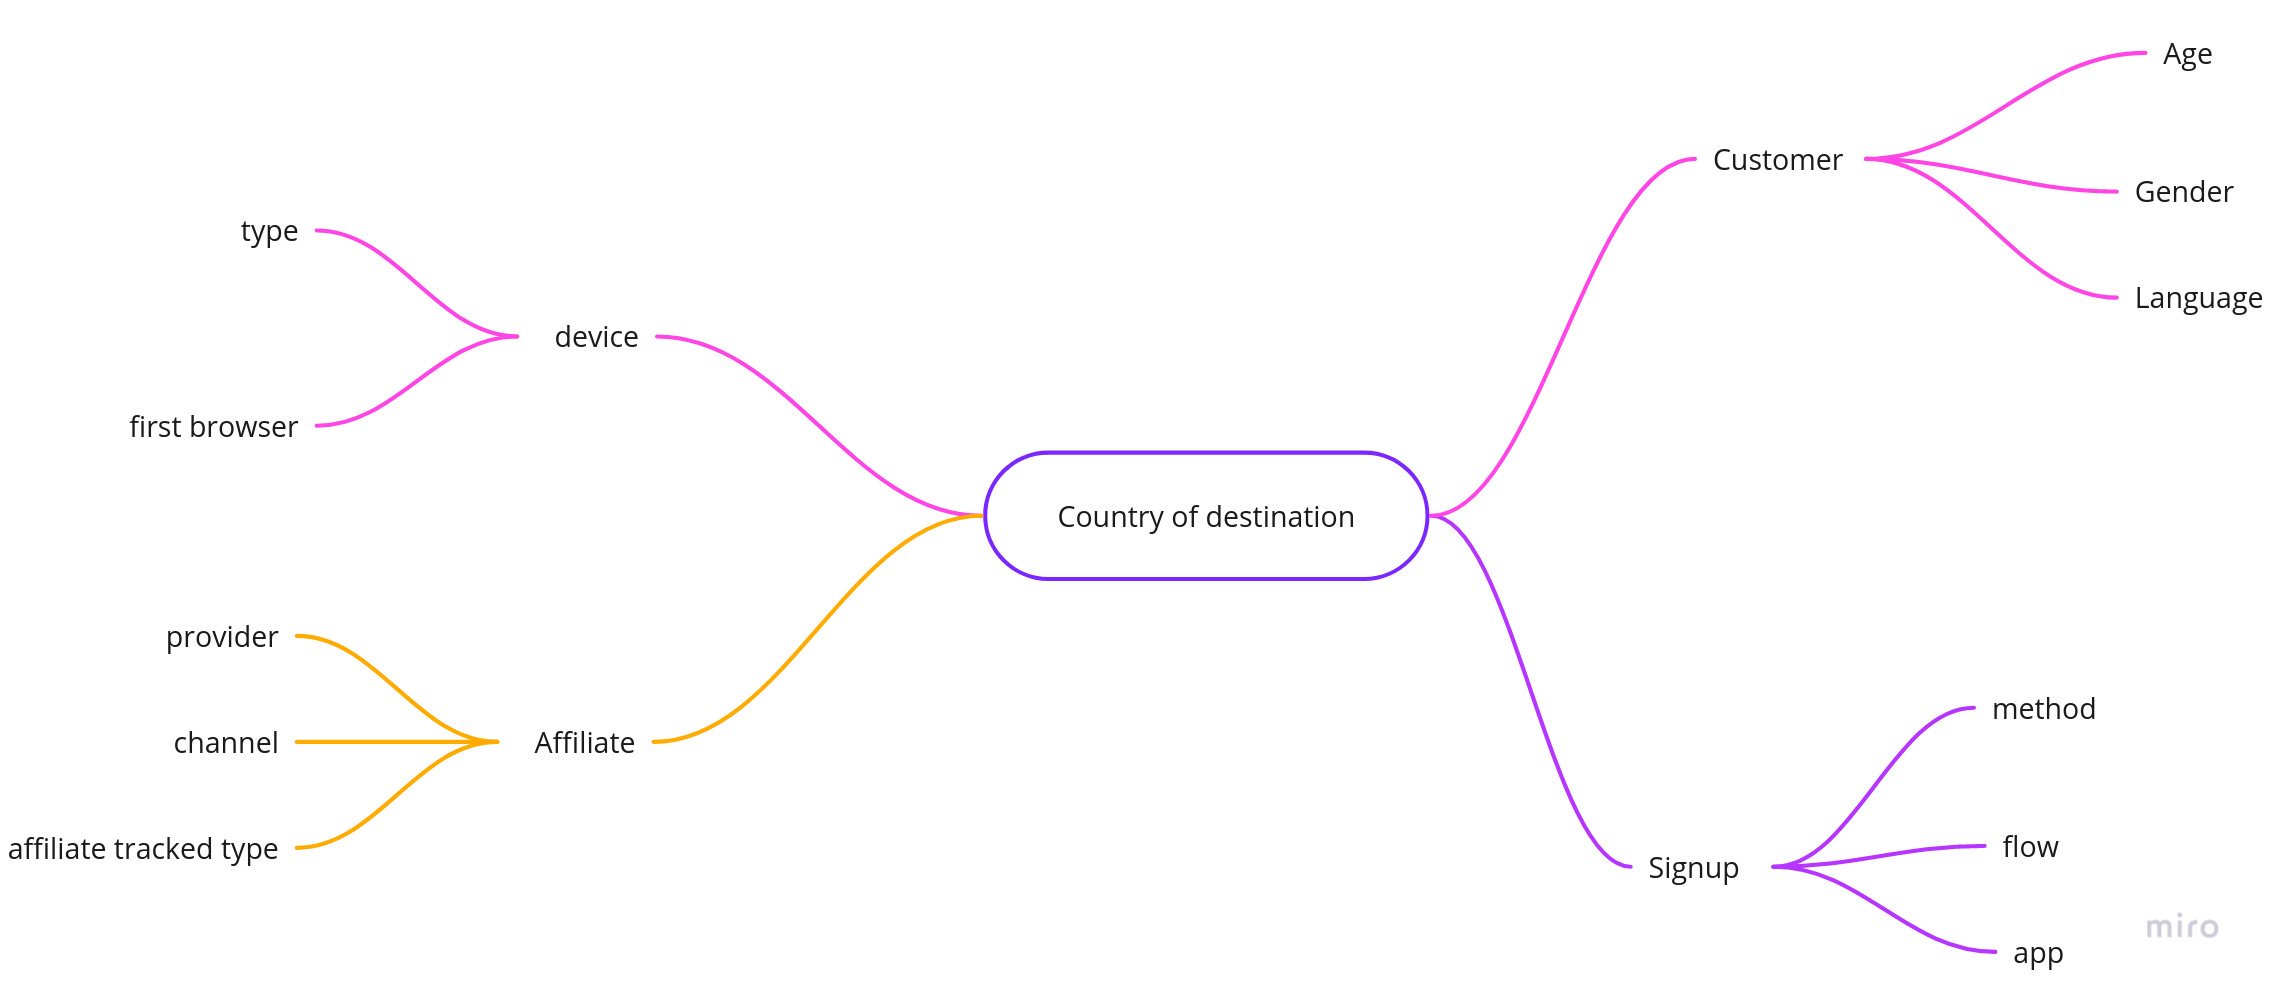

In [36]:
Image('Mind_Map.jpg')

# Data Preparation

# Feature Selection

In [62]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop(cols_drop, axis=1)

In [63]:
predictors = df4.drop('country_destination').copy()
response = df4['country_destination']

NameError: name 'df4' is not defined

In [ ]:
Sequential()